In [51]:
 # Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [52]:
# Importing and cleaning our data
column_names = ["Age", "Workclass", "Fnlwgt", "Education", "Education-Num","Marital-Status",
                "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
                "Hrs-Per-Week", "Native-Country", "Income"]

train_df = pd.read_csv("adult.data", names=column_names, sep=r",\s+", na_values="?", engine="python")
test_df = pd.read_csv("adult.test", names=column_names, sep=r",\s+", na_values="?", engine="python", skiprows=1)

train_df.columns = train_df.columns.str.strip()  
test_df.columns = test_df.columns.str.strip()

train_df = train_df.dropna()
test_df = test_df.dropna()

train_df.head()
test_df.head()

,Age,Workclass,Fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hrs-Per-Week,Native-Country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


In [53]:
# Explore initial data overview
print(train_df.describe())
print(train_df.info())
print(train_df.isnull().sum())  # Check for missing values

                Age        Fnlwgt  Education-Num  Capital-Gain  Capital-Loss  \
count  30162.000000  3.016200e+04   30162.000000  30162.000000  30162.000000   
mean      38.437902  1.897938e+05      10.121312   1092.007858     88.372489   
std       13.134665  1.056530e+05       2.549995   7406.346497    404.298370   
min       17.000000  1.376900e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.176272e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.784250e+05      10.000000      0.000000      0.000000   
75%       47.000000  2.376285e+05      13.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       Hrs-Per-Week  
count  30162.000000  
mean      40.931238  
std       11.979984  
min        1.000000  
25%       40.000000  
50%       40.000000  
75%       45.000000  
max       99.000000  
<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data colum

/var/folders/dd/31s6ldxd2rb88cmcdhr4c2g80000gn/T/ipykernel_494/464479361.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Income'] = train_df['Income'].replace({'<=50K': 0, '>50K': 1})


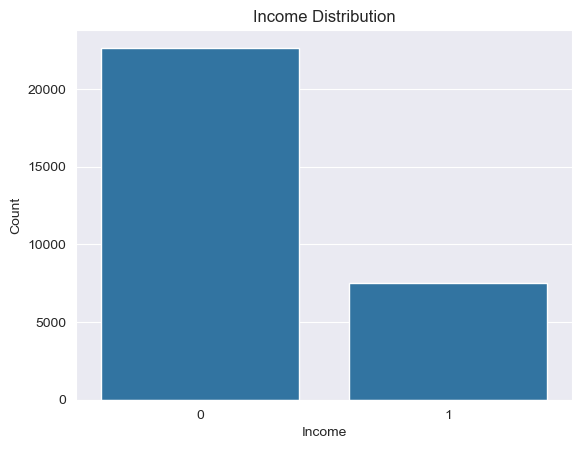

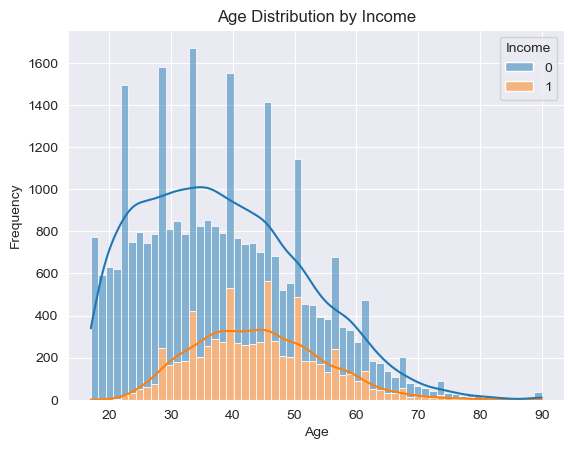

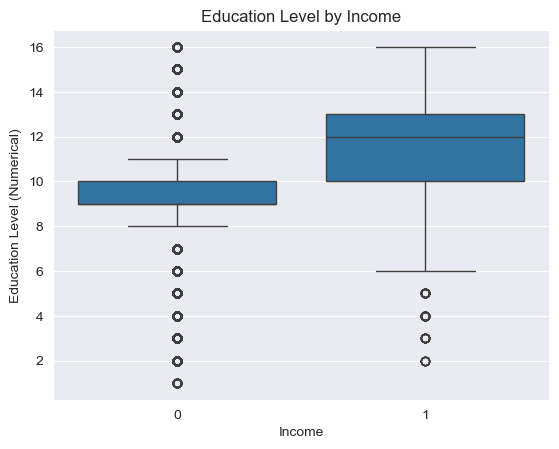

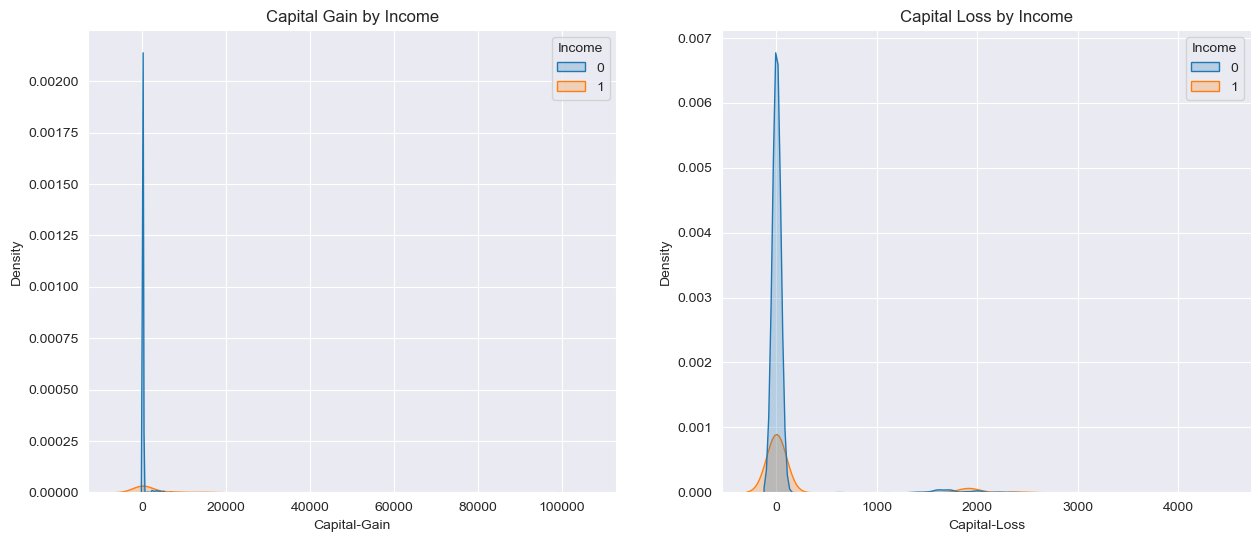

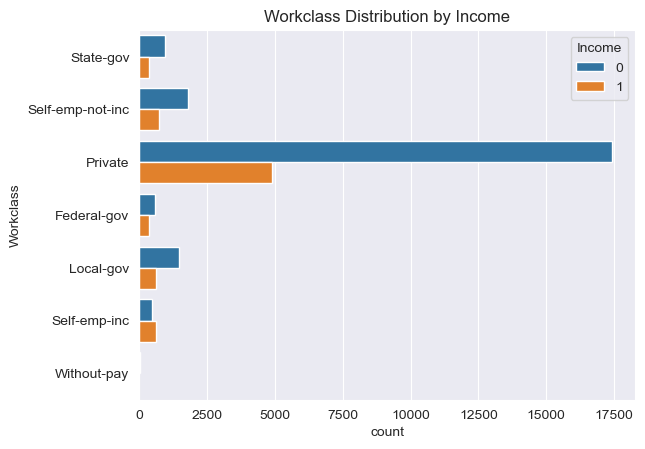

In [54]:
# Exploratory Data Analysis (EDA)

train_df['Income'].value_counts()

# 1. Income Distribution
# Convert target variable 'Income' to binary
train_df['Income'] = train_df['Income'].replace({'<=50K': 0, '>50K': 1})
sns.countplot(x='Income', data=train_df)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

# 2. Age Distribution by Income
sns.histplot(data=train_df, x='Age', hue='Income', kde=True, multiple='stack')
plt.title('Age Distribution by Income')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 3. Education Level by Income
sns.boxplot(x='Income', y='Education-Num', data=train_df)
plt.title('Education Level by Income')
plt.xlabel('Income')
plt.ylabel('Education Level (Numerical)')
plt.show()

# 4. Capital Gain and Capital Loss by Income
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.kdeplot(data=train_df, x='Capital-Gain', hue='Income', fill=True, ax=ax[0])
sns.kdeplot(data=train_df, x='Capital-Loss', hue='Income', fill=True, ax=ax[1])
ax[0].set_title('Capital Gain by Income')
ax[1].set_title('Capital Loss by Income')
plt.show()

# 5. Workclass by Income
sns.countplot(y='Workclass', hue='Income', data=train_df)
plt.title('Workclass Distribution by Income')
plt.show()

Age                 Axes(0.125,0.798085;0.168478x0.0819149)
Fnlwgt           Axes(0.327174,0.798085;0.168478x0.0819149)
Education-Num    Axes(0.529348,0.798085;0.168478x0.0819149)
Capital-Gain     Axes(0.731522,0.798085;0.168478x0.0819149)
Capital-Loss        Axes(0.125,0.699787;0.168478x0.0819149)
Hrs-Per-Week     Axes(0.327174,0.699787;0.168478x0.0819149)
Income           Axes(0.529348,0.699787;0.168478x0.0819149)
dtype: object

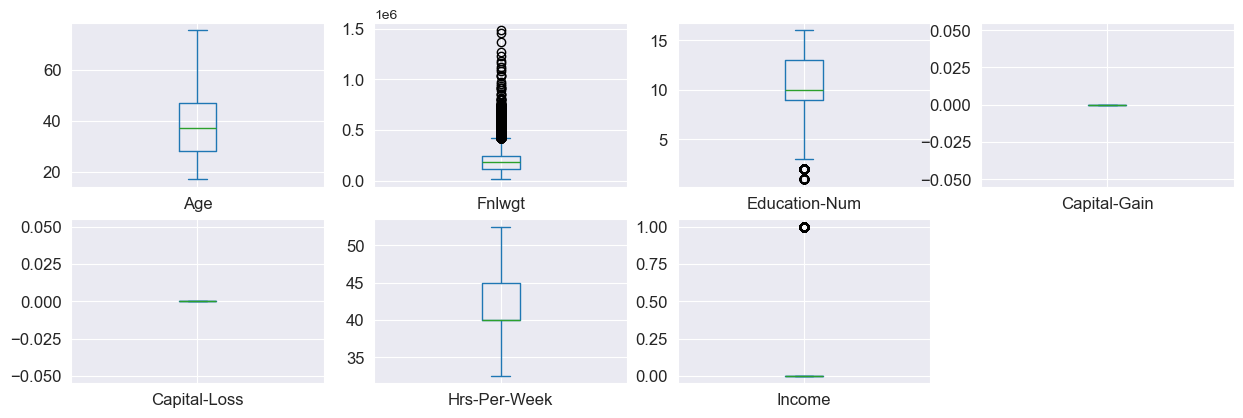

In [55]:
# Outlier Treatment
# Cap outliers in numerical features using IQR method
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# Apply capping on relevant numerical features
for col in ['Age', 'Capital-Gain', 'Capital-Loss', 'Hrs-Per-Week']:
    cap_outliers(train_df, col)

# Boxplot after outlier treatment to check
data_mean = train_df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(8, 4), sharex=False, sharey=False, fontsize=12, figsize=(15, 20))

In [66]:
# Define categorical features and encoding details
ordinal_features = ['Education']
one_hot_features = ['Workclass', 'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native-Country']

train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

ordinal_encoder = OrdinalEncoder()
train_df[ordinal_features] = ordinal_encoder.fit_transform(train_df[ordinal_features])
test_df[ordinal_features] = ordinal_encoder.transform(test_df[ordinal_features])

already_encoded = any(feature + '_' in col for col in train_df.columns for feature in one_hot_features)

if not already_encoded:
    # Only perform one-hot encoding if it hasn't been done already
    train_df = pd.get_dummies(train_df, columns=one_hot_features)
    test_df = pd.get_dummies(test_df, columns=one_hot_features)

train_columns = train_df.columns
test_df = test_df.reindex(columns=train_columns, fill_value=0)


In [68]:
#feature normalisation and scaling 
from sklearn.preprocessing import StandardScaler

# Split into X and y for train and test sets
X_train = train_df.drop('Income', axis=1)
y_train = train_df['Income']
X_test = test_df.drop('Income', axis=1)
y_test = test_df['Income']

print("Unique values in y_train before replacement:", y_train.unique())
print("Unique values in y_test before replacement:", y_test.unique())

# Convert labels in y_train and y_test to binary values
train_df['Income'] = train_df['Income'].replace({'<=50K.': 0, '>50K.': 1, '<=50K': 0, '>50K': 1}).astype(int)
test_df['Income'] = test_df['Income'].replace({'<=50K.': 0, '>50K.': 1, '<=50K': 0, '>50K': 1}).astype(int)

y_train = train_df['Income']
y_test = test_df['Income']

print("Unique values in y_train after conversion:", y_train.unique())
print("Unique values in y_test after conversion:", y_test.unique())

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Unique values in y_train before replacement: [0 1]
Unique values in y_test before replacement: [0 1]
Unique values in y_train after conversion: [0 1]
Unique values in y_test after conversion: [0 1]


Original number of features: 89
Reduced number of features after PCA: 72


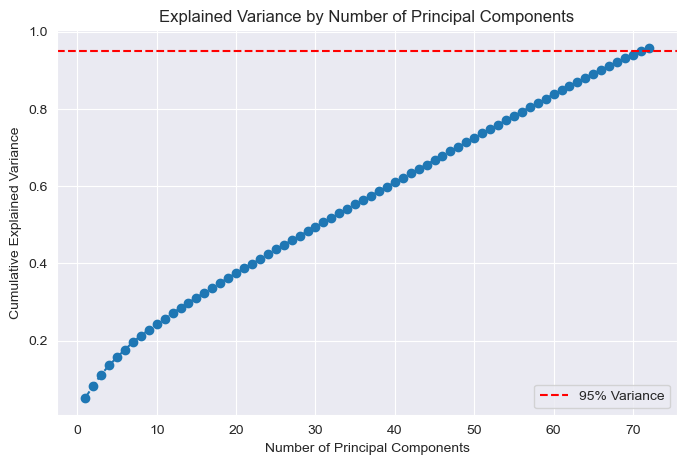

In [72]:
# Initialize PCA, fit and transform on the training data
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)

print("Original number of features:", X_train.shape[1])
print("Reduced number of features after PCA:", X_train_pca.shape[1])

import matplotlib.pyplot as plt
import numpy as np

# Plot the explained variance for each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
# SVM Model Training

#from sklearn.experimental import enable_halving_search_cv  
#from sklearn.model_selection import HalvingGridSearchCV
#param_grid = {
#    'C': [0.1, 1, 10, 100],
#    'gamma': [0.001, 0.01, 0.1, 1],
#}
#halving_grid_search = HalvingGridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, factor=2, cv=5, verbose=3)
#halving_grid_search.fit(Xs, y)
#print("Best parameters found: ", halving_grid_search.best_params_)

classifier = SVC(kernel='rbf', C=10, gamma=0.01, class_weight= 'balanced')
classifier.fit(X_train_pca, y_train)

SVC(C=10, class_weight='balanced', gamma=0.01)

In [74]:
# Model Evaluation
## Predictions and classification report
y_pred = classifier.predict(X_test_pca)
print(classification_report(y_test, y_pred))

## Cross-validation scores
scores = cross_val_score(classifier, X_train_pca, y_train, cv=5)
print(f"Cross-Validation Scores: {scores}")

              precision    recall  f1-score   support

           0       0.93      0.75      0.83     11360
           1       0.52      0.83      0.64      3700

    accuracy                           0.77     15060
   macro avg       0.73      0.79      0.74     15060
weighted avg       0.83      0.77      0.78     15060

Cross-Validation Scores: [0.77689375 0.76031825 0.77453581 0.7793435  0.77188329]
